Вводная часть

    * Описание задачи
    * Краткий вывод по проделанной работы
    
1 Шаг. предобработка данных

    * открытие и просмотр данных
    * проверка на дубликаты
    * проверка на пропуски
    * проверка на ошибки и аномалии
    * просмотр и редактирование типов данных
    * добавление необходимых столбцов
    1.1 вывод по шагу
    
2 Шаг. анализ данных

    2.1 подсчет retention rate
    2.2 расчет времени которое пользователи проводят в приложение
    2.3 расчет частоты проведений событий
    2.4 расчет конверсии в целевое действие 'contacts_show'
    2.5 вывод по шагу
    
3 Шаг. Разделение всех пользователей на группы

    3.1 распределение по браузеру(гугл, яндекс, другие)
    3.2 распределение по времени(утро, день, вечер, ночь)
    3.3 для каждой группы считаем Retention rate    
    3.4 для каждой группы считаем конверсию
    3.5 вывод

4 Шаг. Проверка гипотез

    4.1 проверка гипотезы "различие конверсии пользователей гугл браузера и яндекс браузера"
    4.2 проверка гипотезы "целевое действие('contacts_show') происходит чаще днем чем вечером"
    4.3 вывод
    
5 Шаг. Общий вывод


# Вводная часть

Задачи
- **Провести исследовательский анализ данных**
- **Сегментироватьь пользователей на основе действий**
- **Проверить статистические гипотезы**

Краткий вывод 

- **Разницы конверсии пользователей Google и Yandex браузера не выявлено, из этого следует, что поток пользователей и покупателей из этих источников одинаковый**
- **Пользователи чаще совершают целевое действие после обеда (14:00) нежели утром**


<a id="1"></a> 
## Шаг. Предобработка данных

In [55]:
#импорт необходимых библиотек
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import math as mth
import scipy.stats as st
import plotly.express as px
import seaborn as sns
from plotly import graph_objects as go


In [56]:
#читаем файлы с серверов
mobile_sourсes = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_soures.csv')
mobile_dataset = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_dataset.csv')

In [57]:
#просмотр первых строк 
mobile_sourсes.head()

,userId,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google


In [58]:
#просмотр информации
mobile_sourсes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


In [59]:
#переименование столбца
mobile_sourсes = mobile_sourсes.rename(columns={'userId':'user_id'})

# подсчёт количества дубликатов
mobile_sourсes.duplicated().sum()


0

In [60]:
#просмотр названий браузеров 
mobile_sourсes['source'].value_counts().sort_index()

google    1129
other     1230
yandex    1934
Name: source, dtype: int64

In [61]:
#просмотр первых строк 
mobile_dataset.head()

,event.time,event.name,user.id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c


In [62]:
#просмотр информации
mobile_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


In [63]:
#переименование столбца
mobile_dataset.columns = ['event_time', 'event_name','user_id']

# подсчёт количества дубликатов
mobile_dataset.duplicated().sum()

0

In [64]:
#просмотр названий событий
mobile_dataset['event_name'].value_counts().sort_index()

advert_open       6164
contacts_call      541
contacts_show     4450
favorites_add     1417
map               3881
photos_show      10012
search_1          3506
search_2           324
search_3           522
search_4           701
search_5          1049
search_6           460
search_7           222
show_contacts       79
tips_click         814
tips_show        40055
Name: event_name, dtype: int64

Названия событий 'search_1','search_2' и т.д. переименуем в 'search', а 'show_contacts' в 'contacts_show'

In [65]:
#Замена 'search_*' на 'search'
#cоздаю переменную для более быстрого выполнения цикла
tempo = mobile_dataset['event_name'].str.contains('search') 
for i in range(len(mobile_dataset['event_name'])):
    if tempo[i] == True:
        mobile_dataset.loc[i,'event_name'] = 'search'
        
#замена "show_contacts" на "contacts_show"
mobile_dataset.loc[mobile_dataset['event_name'] == 'show_contacts', 'event_name'] =  'contacts_show'
#просмотр названий событий(проверка)
mobile_dataset['event_name'].value_counts().sort_index()


advert_open       6164
contacts_call      541
contacts_show     4529
favorites_add     1417
map               3881
photos_show      10012
search            6784
tips_click         814
tips_show        40055
Name: event_name, dtype: int64

In [66]:
#изменения пита данных в столбце со временем (event_time) на дату(datetime64)
mobile_dataset['event_time'] = pd.to_datetime(mobile_dataset['event_time'], format='%Y-%m-%d %H:%M:%S')
mobile_dataset['event_time'] = mobile_dataset['event_time'].dt.round('1S')
#mobile_dataset.info()

In [67]:
#простр первой даты из данных
mobile_dataset['event_time'].min()

Timestamp('2019-10-07 00:00:00')

In [68]:
#простр последней даты из данных
mobile_dataset['event_time'].max()

Timestamp('2019-11-03 23:58:13')

Данные предоставлены за 28 дней, из них 20 рабочих

<a id="11"></a> 
### Вывод по 1 шагу

В ходе выполнения первого шага были проделаны следующие действия:

    * чтение файлов mobile_soures.csv и mobile_dataset.csv и запись их в соответствующие переменные
    * просмотр данных
    * переименование столбцов
    * проверили на дубликаты   
    * перевод в формат datetime64[ns] столбца со временем 
    * заменили 'search_*' на 'search'
    * заменили 'show_contacts' на 'contacts_show'
В распоряжении имеются данные за 28 дней со сведениями о:

    * 4293 пользователях
    * 74197 событиях

<a id="2"></a> 
## Шаг. Aнализ данных

<a id="21"></a> 
### Подсчет retention rate

In [69]:
#соедидение таблиц mobile_dataset и mobile_sourсes
mobile_dataset = mobile_dataset.merge(mobile_sourсes, how='inner')
#проверка того, что все пользователи сохранились без потерь 
len(mobile_dataset['user_id'].unique())

4293

In [70]:
# функция для создания пользовательских профилей

def get_profiles(events, event_names=[]):

    # находим параметры первых посещений
    profiles = (events.sort_values(by=['user_id', 'event_time'])
                        .groupby('user_id')
                        .agg({'event_time': 'first',
                              'event_time_copy': 'last', 
                              'source': 'first'})
                        .rename(columns={'event_time': 'first_ts',
                                         'event_time_copy': 'last_ts'})
                        .reset_index()
                )

    # для когортного анализа определяем дату первого посещения
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['dt'] = pd.to_datetime(profiles['dt'], format='%Y-%m-%d')

    temp = mobile_dataset[mobile_dataset['event_name'] == 'contacts_show']
    temp = temp['user_id'].unique()
    #profiles['payer'] = np.nan
    profiles['payer'] = False
    for i in range(len(profiles)):        
        if profiles['user_id'][i] in temp:
            profiles.loc[i, 'payer']  = True
    
            
    return profiles
 

In [71]:
#создаем еще один столбец со временем для коректной работы функции
mobile_dataset['event_time_copy'] = mobile_dataset['event_time']
#пррименяем функцию
profiles = get_profiles(mobile_dataset)
#удаление столбца 'event_time_copy'
mobile_dataset = mobile_dataset.drop(columns=['event_time_copy'])
#вывод профилей пользователей
profiles

,user_id,first_ts,last_ts,source,dt,payer
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:39:46,2019-10-22 11:30:53,other,2019-10-07,False
1,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-19 21:34:34,2019-11-03 17:12:10,yandex,2019-10-19,True
2,00463033-5717-4bf1-91b4-09183923b9df,2019-11-01 13:54:35,2019-11-01 14:19:18,yandex,2019-11-01,False
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,2019-10-18 22:14:06,2019-10-31 21:42:16,google,2019-10-18,False
4,00551e79-152e-4441-9cf7-565d7eb04090,2019-10-25 16:44:41,2019-10-29 02:17:12,yandex,2019-10-25,True
...,...,...,...,...,...,...
4288,ffab8d8a-30bb-424a-a3ab-0b63ebbf7b07,2019-10-13 16:11:27,2019-10-26 19:53:52,yandex,2019-10-13,False
4289,ffc01466-fdb1-4460-ae94-e800f52eb136,2019-10-07 20:32:50,2019-10-07 20:33:42,yandex,2019-10-07,True
4290,ffcf50d9-293c-4254-8243-4890b030b238,2019-10-23 11:51:35,2019-10-23 11:52:56,google,2019-10-23,False
4291,ffe68f10-e48e-470e-be9b-eeb93128ff1a,2019-10-21 16:39:34,2019-10-28 07:17:53,yandex,2019-10-21,True


profiles таблица, содержащая в себе профили пользователей 

    * user_id - уникальный ID пользователя
    * first_ts - дата и время первого посещения приложения 
    * last_ts - дата и время первого посещения приложения 
    * source -  источник, с которого пользователь установил приложение (yandex, google, other)
    * dt - дата первого посещения 
    * payer - показатель целевого действия


In [72]:
#задаем дату анализа и горизон в 7 дней
observation_date = datetime(2019, 11, 3).date()
horizon_days = 7

In [73]:
# функция для расчёта удержания
#
def get_retention(
                profiles,
                evensts,
                observation_date,
                horizon_days,
                dimensions=[],
                ignore_horizon=False,
                ):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days=horizon_days - 1)
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
                                  evensts[['user_id', 'event_time']],
                                  on='user_id',
                                  how='left'
                                  )
    result_raw['lifetime'] = (result_raw['event_time'] - result_raw['first_ts']).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(index=dims,
                                columns='lifetime',
                                values='user_id',
                                aggfunc='nunique'
                               )
        cohort_sizes = (df.groupby(dims)
                          .agg({'user_id': 'nunique'})
                          .rename(columns={'user_id': 'cohort_size'})
                       )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

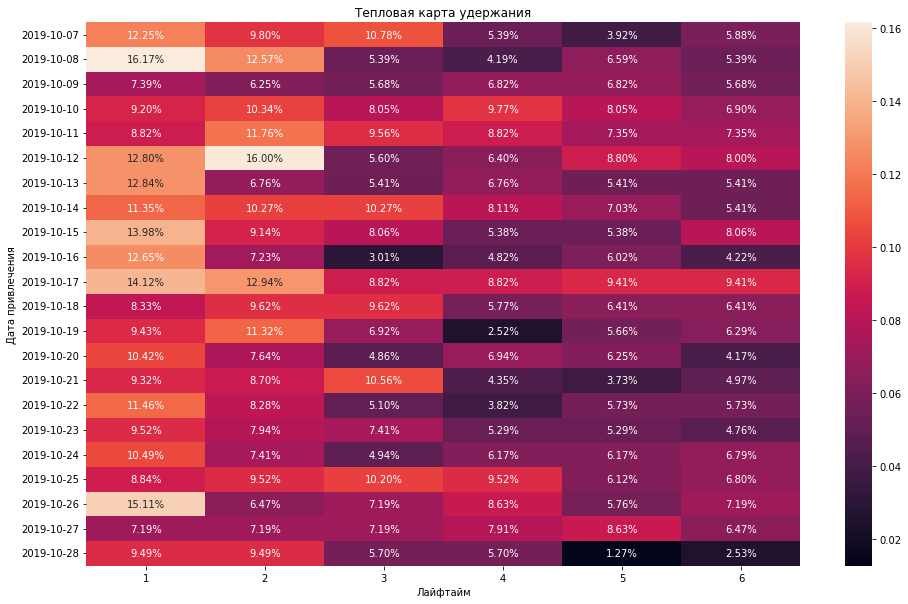

In [74]:
tempo = profiles.loc[:, ['user_id','first_ts','last_ts','source','dt']]
tempo['payer'] = True
dimensions= []
(retention_raw,
 retention_grouped,
 retention_history) = get_retention(tempo,
                                      mobile_dataset,
                                      observation_date,
                                      horizon_days,
                      
                                    dimensions=dimensions
                                     )
tempo = retention_history.reset_index().drop(columns=['payer'])
tempo['dt'] = tempo['dt'].dt.strftime('%Y-%m-%d')
tempo = tempo.rename(columns={'dt':'Дата привлечения'})
tempo = tempo.set_index('Дата привлечения')

# строим хитмэп

plt.figure(figsize=(16, 10))  # задаём размер графика
sns.heatmap(
    tempo.drop(columns=['cohort_size', 0]),  # удаляем лишние столбцы
    annot=True,  # включаем подписи
    fmt='.2%',  # переводим значения в проценты
)
plt.title('Тепловая карта удержания')  # название графика
plt.xlabel('Лайфтайм')
plt.show()

In [75]:
tempo.mean()

cohort_size    161.272727
0                1.000000
1                0.109630
2                0.093935
3                0.072873
4                0.064504
5                0.061723
6                0.060832
dtype: float64

На первый взгляд видно, что те, кто зарегистрировались 16 числа, чаще других возвращались в приложение, а вот пользователи от 27го таким похвастаться не могут

Если посмотреть на средние значения каждого лайфтайма, то видно, что в первый день в среднем возвращается примерно 10% пользователей, на второй 9%, а далее 6-7% для каждого дня


<a id="22"></a> 
### Расчет времени которое пользователи проводят в приложение

Посмотрим на сессии более детально, на их продолжительность и кол-во для каждого пользователя

Примем условие - если пользователь в течении часа не совершал действий то сессия была закончена последним действием

In [76]:
#Создание таблицы
#создаем копию
tempo = mobile_dataset.copy()
#cоздаем столбец number c ячейками со значением 1000000
tempo['number_session'] = 1000000 #для самопроверки
a = 0
#запускаем цил перебора индексов без последнего 
for i in range((len(tempo))-1):
            # елси разница в соседних event_time меньше 3600 сек
        if ((tempo.loc[i+1,'event_time'].timestamp() - tempo.loc[i,'event_time'].timestamp() < 3600) &
            # и ID юзеров одинакове
            (tempo.loc[i,'user_id'] == tempo.loc[i+1,'user_id'])):
            #присваеваем условный номер сесии этой строрке
            tempo.loc[i,'number_session'] = a
            #иначе придавлем у номеру сессии 1
        else:
            tempo.loc[i,'number_session'] = a
            a+=1
#копируем в последнюю строку номер сессии из пердыдущей строки
tempo.loc[(len(tempo)-1),'number_session'] = tempo.loc[(len(tempo)-2),'number_session']
tempo

,event_time,event_name,user_id,source,number_session
0,2019-10-07 00:00:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,0
1,2019-10-07 00:00:01,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,0
2,2019-10-07 00:00:07,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,0
3,2019-10-07 00:01:28,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,0
4,2019-10-07 00:01:35,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,0
...,...,...,...,...,...
74192,2019-11-03 23:46:47,map,d157bffc-264d-4464-8220-1cc0c42f43a9,google,9572
74193,2019-11-03 23:46:59,advert_open,d157bffc-264d-4464-8220-1cc0c42f43a9,google,9572
74194,2019-11-03 23:47:01,tips_show,d157bffc-264d-4464-8220-1cc0c42f43a9,google,9572
74195,2019-11-03 23:47:47,advert_open,d157bffc-264d-4464-8220-1cc0c42f43a9,google,9572


Мы получили столбец number_session который показывает номер сессии, теперь с его помощью посмотрим на протяженность каждой сессии

In [77]:
#создает таблицу сессий
sessions = tempo.groupby('number_session').first().loc[:, ['user_id','event_time']]
#перееименование столбца
sessions = sessions.rename(columns={'event_time':'start_session'})
#добавляем столбец
sessions['end_session'] = tempo.groupby('number_session').last().loc[:,'event_time']
#считаем продолжительность сессии
sessions['session_length'] = sessions['end_session']-sessions['start_session']
#считаем продолжительностьь сессии в секундах
for i in range(len(sessions)):
    sessions.loc[i,'session_length_s'] = sessions.loc[i,'end_session'].timestamp()- sessions.loc[i,'start_session'].timestamp()
sessions['dt'] = sessions['start_session'].dt.round('1D')
#если есть сесиия с номер 1000000 значит ест ошибка, или сессий больше 1000000
sessions


,user_id,start_session,end_session,session_length,session_length_s,dt
number_session,,,,,,
0,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07 00:00:00,2019-10-07 00:18:43,0 days 00:18:43,1123.0,2019-10-07
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,2019-10-07 00:00:02,2019-10-07 00:41:40,0 days 00:41:38,2498.0,2019-10-07
2,cf7eda61-9349-469f-ac27-e5b6f5ec475c,2019-10-08 20:06:42,2019-10-08 20:19:08,0 days 00:12:26,746.0,2019-10-09
3,cf7eda61-9349-469f-ac27-e5b6f5ec475c,2019-10-10 19:43:23,2019-10-10 20:12:33,0 days 00:29:10,1750.0,2019-10-11
4,cf7eda61-9349-469f-ac27-e5b6f5ec475c,2019-10-16 21:17:07,2019-10-16 22:02:51,0 days 00:45:44,2744.0,2019-10-17
...,...,...,...,...,...,...
9568,b86fe56e-f2de-4f8a-b192-cd89a37ecd41,2019-11-03 23:10:03,2019-11-03 23:24:56,0 days 00:14:53,893.0,2019-11-04
9569,424c0ae1-3ea3-4f1e-a814-6bac73e48ab1,2019-11-03 23:22:52,2019-11-03 23:45:20,0 days 00:22:28,1348.0,2019-11-04
9570,437a4cd4-9ba9-457f-8614-d142bc48fbeb,2019-11-03 23:44:22,2019-11-03 23:45:55,0 days 00:01:33,93.0,2019-11-04


Добавим показатель совершения целевого действия в столбец "contacts_show":
True если было и False если не было

In [78]:
#создаем столбец
sessions['contacts_show'] = False
#ц
for i in range(len(tempo)):
    #eсли значение в колонке 'event_name' равно 'contacts_show'
    if tempo.loc[i,'event_name'] == 'contacts_show':        
        #тогда присвоть sessions значение True ячейке из столбца 'contacts_show' с индексом равном 'number_session'
        sessions.loc[tempo.loc[i,'number_session'],'contacts_show'] = True
sessions

,user_id,start_session,end_session,session_length,session_length_s,dt,contacts_show
number_session,,,,,,,
0,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07 00:00:00,2019-10-07 00:18:43,0 days 00:18:43,1123.0,2019-10-07,False
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,2019-10-07 00:00:02,2019-10-07 00:41:40,0 days 00:41:38,2498.0,2019-10-07,False
2,cf7eda61-9349-469f-ac27-e5b6f5ec475c,2019-10-08 20:06:42,2019-10-08 20:19:08,0 days 00:12:26,746.0,2019-10-09,False
3,cf7eda61-9349-469f-ac27-e5b6f5ec475c,2019-10-10 19:43:23,2019-10-10 20:12:33,0 days 00:29:10,1750.0,2019-10-11,False
4,cf7eda61-9349-469f-ac27-e5b6f5ec475c,2019-10-16 21:17:07,2019-10-16 22:02:51,0 days 00:45:44,2744.0,2019-10-17,False
...,...,...,...,...,...,...,...
9568,b86fe56e-f2de-4f8a-b192-cd89a37ecd41,2019-11-03 23:10:03,2019-11-03 23:24:56,0 days 00:14:53,893.0,2019-11-04,False
9569,424c0ae1-3ea3-4f1e-a814-6bac73e48ab1,2019-11-03 23:22:52,2019-11-03 23:45:20,0 days 00:22:28,1348.0,2019-11-04,False
9570,437a4cd4-9ba9-457f-8614-d142bc48fbeb,2019-11-03 23:44:22,2019-11-03 23:45:55,0 days 00:01:33,93.0,2019-11-04,False


session таблица, содержащая в себе профили пользователей 

    * user_id - уникальный ID пользователя
    * start_session - время начала сессии
    * end_session - время последнего действия в сессии 
    * session_length - время сессии
    * dt - дата начала сессии
    * contacts_show - показатель целевого действия в сессии
    


Таблица содержит нулевые сессии, тоесть сессии которые были соверщены только одним действием, и их продолжителность была равна 0 секунд, удалим эти сессии чтобы они не искажали картину

In [79]:
#переписываем таблицу без сессий длинна который 0 сек
sessions = sessions.loc[sessions['session_length_s'] != 0]
# так как индексы были номерами сессий, удаляем их
sessions = sessions.reset_index().drop(columns=['number_session'])
#добавляем заново и переименновываем
sessions = sessions.reset_index().rename(columns={'index':'number_session'})
#делаем индексами
sessions = sessions.set_index('number_session')
sessions

,user_id,start_session,end_session,session_length,session_length_s,dt,contacts_show
number_session,,,,,,,
0,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07 00:00:00,2019-10-07 00:18:43,0 days 00:18:43,1123.0,2019-10-07,False
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,2019-10-07 00:00:02,2019-10-07 00:41:40,0 days 00:41:38,2498.0,2019-10-07,False
2,cf7eda61-9349-469f-ac27-e5b6f5ec475c,2019-10-08 20:06:42,2019-10-08 20:19:08,0 days 00:12:26,746.0,2019-10-09,False
3,cf7eda61-9349-469f-ac27-e5b6f5ec475c,2019-10-10 19:43:23,2019-10-10 20:12:33,0 days 00:29:10,1750.0,2019-10-11,False
4,cf7eda61-9349-469f-ac27-e5b6f5ec475c,2019-10-16 21:17:07,2019-10-16 22:02:51,0 days 00:45:44,2744.0,2019-10-17,False
...,...,...,...,...,...,...,...
7788,b86fe56e-f2de-4f8a-b192-cd89a37ecd41,2019-11-03 23:10:03,2019-11-03 23:24:56,0 days 00:14:53,893.0,2019-11-04,False
7789,424c0ae1-3ea3-4f1e-a814-6bac73e48ab1,2019-11-03 23:22:52,2019-11-03 23:45:20,0 days 00:22:28,1348.0,2019-11-04,False
7790,437a4cd4-9ba9-457f-8614-d142bc48fbeb,2019-11-03 23:44:22,2019-11-03 23:45:55,0 days 00:01:33,93.0,2019-11-04,False


Добавим в таблицу profiles количество сессий у каждого пользователя

In [80]:
tempo = sessions.groupby('user_id').count()
tempo = tempo.reset_index().drop(columns = ['end_session','session_length','session_length_s','dt','contacts_show'])
profiles = profiles.merge(tempo, how = 'inner')
profiles = profiles.rename(columns={'start_session':'count_session'})
profiles

,user_id,first_ts,last_ts,source,dt,payer,count_session
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:39:46,2019-10-22 11:30:53,other,2019-10-07,False,4
1,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-19 21:34:34,2019-11-03 17:12:10,yandex,2019-10-19,True,5
2,00463033-5717-4bf1-91b4-09183923b9df,2019-11-01 13:54:35,2019-11-01 14:19:18,yandex,2019-11-01,False,1
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,2019-10-18 22:14:06,2019-10-31 21:42:16,google,2019-10-18,False,6
4,00551e79-152e-4441-9cf7-565d7eb04090,2019-10-25 16:44:41,2019-10-29 02:17:12,yandex,2019-10-25,True,2
...,...,...,...,...,...,...,...
4203,ffab8d8a-30bb-424a-a3ab-0b63ebbf7b07,2019-10-13 16:11:27,2019-10-26 19:53:52,yandex,2019-10-13,False,2
4204,ffc01466-fdb1-4460-ae94-e800f52eb136,2019-10-07 20:32:50,2019-10-07 20:33:42,yandex,2019-10-07,True,1
4205,ffcf50d9-293c-4254-8243-4890b030b238,2019-10-23 11:51:35,2019-10-23 11:52:56,google,2019-10-23,False,1
4206,ffe68f10-e48e-470e-be9b-eeb93128ff1a,2019-10-21 16:39:34,2019-10-28 07:17:53,yandex,2019-10-21,True,3


In [81]:
#Рейтинг категорий

tempo = (profiles.groupby('count_session')['user_id']
        .count()
        .sort_values(ascending=False)
        .reset_index()
        )
fig = px.histogram(tempo.head(7),
                   x='count_session',
                   y='user_id',
                   histfunc='sum',
                   title='Частота использования приложений пользователями',
                   nbins=7)
fig.show()

In [82]:
fig = px.box(profiles['count_session'])
fig.show()

In [83]:
tempo = (tempo.loc[3:,'user_id'].sum()/tempo['user_id'].sum()*100).round(2)
print(f'Примерно {tempo} % пользователей заходят приложение чрезвычайно часто')

Примерно 8.63 % пользователей заходят приложение чрезвычайно часто


Судя по графикам люди чаще всего заходят в приложение 1-3 раза, доля таких пользователей примерно 91%

In [84]:
sessions['session_length'].median()

Timedelta('0 days 00:10:44')

In [85]:
fig = px.box(sessions['session_length_s'])
fig.show()

In [86]:
tempo = sessions.groupby('user_id').sum()
tempo = tempo.reset_index().drop(columns = ['contacts_show'])
profiles = profiles.merge(tempo, how = 'inner')
profiles['avg_time_session_m'] = round((profiles['session_length_s']/profiles['count_session'])/60)
profiles

,user_id,first_ts,last_ts,source,dt,payer,count_session,session_length_s,avg_time_session_m
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:39:46,2019-10-22 11:30:53,other,2019-10-07,False,4,2760.0,12.0
1,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-19 21:34:34,2019-11-03 17:12:10,yandex,2019-10-19,True,5,11775.0,39.0
2,00463033-5717-4bf1-91b4-09183923b9df,2019-11-01 13:54:35,2019-11-01 14:19:18,yandex,2019-11-01,False,1,1483.0,25.0
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,2019-10-18 22:14:06,2019-10-31 21:42:16,google,2019-10-18,False,6,6644.0,18.0
4,00551e79-152e-4441-9cf7-565d7eb04090,2019-10-25 16:44:41,2019-10-29 02:17:12,yandex,2019-10-25,True,2,560.0,5.0
...,...,...,...,...,...,...,...,...,...
4203,ffab8d8a-30bb-424a-a3ab-0b63ebbf7b07,2019-10-13 16:11:27,2019-10-26 19:53:52,yandex,2019-10-13,False,2,2965.0,25.0
4204,ffc01466-fdb1-4460-ae94-e800f52eb136,2019-10-07 20:32:50,2019-10-07 20:33:42,yandex,2019-10-07,True,1,52.0,1.0
4205,ffcf50d9-293c-4254-8243-4890b030b238,2019-10-23 11:51:35,2019-10-23 11:52:56,google,2019-10-23,False,1,81.0,1.0
4206,ffe68f10-e48e-470e-be9b-eeb93128ff1a,2019-10-21 16:39:34,2019-10-28 07:17:53,yandex,2019-10-21,True,3,2332.0,13.0


In [87]:
profiles.describe()

,count_session,session_length_s,avg_time_session_m
count,4208.000000,4208.000000,4208.000000
mean,1.851949,2390.778755,20.429658
std,2.289732,5442.622936,23.643142
min,1.000000,1.000000,0.000000
25%,1.000000,412.750000,6.000000
50%,1.000000,1062.500000,13.000000
75%,2.000000,2520.500000,27.000000
max,53.000000,151754.000000,270.000000


В среднем пользователи проводят в приложении 20 минут, но этот показатель завышен из-за любителей часами выбирать товар, посмотим на медианное значение

In [88]:
round(sessions['session_length_s'].median()/60,2)

10.73

Чуть больше 10 с половиной минут обычно пользователь тратит на один сеанс в приложении

In [89]:
round(sessions[sessions['contacts_show']== True]['session_length_s'].median()/60,2)

16.47

А вот медианное значение удачной сессии 16 с половиной минут

<a id="23"></a> 
### Расчет частоты проведений событий

In [90]:
mobile_dataset['dt'] = mobile_dataset['event_time'].dt.round('1D')

#создаем копию
tempo = mobile_dataset.copy()
#меняем тип данных 
#создаем сводную таблицу
tempo = tempo.pivot_table(index = ['user_id','dt'],values = 'source', aggfunc = 'count').reset_index()
#удаляем лишнюю строку
tempo = tempo.drop(columns=['user_id']).rename(columns={'source':'count_session'})
#групируем по нг ID
tempo = tempo.groupby('dt').count().sort_values(by='dt').reset_index()
fig = go.Figure()
fig.add_trace(go.Scatter(x=tempo['dt'], y=tempo['count_session']))
fig.update_layout(title="Частота сессий по дням",
                  yaxis_title="Кол-во сессий")
fig.show()

Нужно более конкретно посмотреть на сессии, какие события чаще всего выполняются изо дня в день

In [91]:
tempo = mobile_dataset.copy()
tempo = tempo.pivot_table(index = ['event_name','dt'], values = 'user_id', aggfunc = 'count').reset_index()
tempo = tempo.pivot_table(index = 'dt', columns = 'event_name',  values = 'user_id', aggfunc = 'sum').reset_index()


fig = go.Figure()

fig.add_trace(go.Scatter(x=tempo['dt'], y = tempo['tips_show'], name='Рекомендованные объявления'))
fig.add_trace(go.Scatter(x=tempo['dt'], y = tempo['tips_click'], name='Кликнул по рекомендованному объявлению'))
fig.add_trace(go.Scatter(x=tempo['dt'], y = tempo['search'], name='Поиск'))
fig.add_trace(go.Scatter(x=tempo['dt'], y = tempo['advert_open'], name='Открытие карточки'))
fig.add_trace(go.Scatter(x=tempo['dt'], y = tempo['photos_show'], name='Просмотр фотографий'))
fig.add_trace(go.Scatter(x=tempo['dt'], y = tempo['map'], name='Открытие карты'))
fig.add_trace(go.Scatter(x=tempo['dt'], y = tempo['contacts_show'], name='Посмотр номера'))
fig.add_trace(go.Scatter(x=tempo['dt'], y = tempo['favorites_add'], name='Добавление в избранное'))
fig.add_trace(go.Scatter(x=tempo['dt'], y = tempo['contacts_call'], name='Звонок продавцу'))

fig.update_layout(title="Частота событий по дням",
                  yaxis_title="Кол-во событий")
fig.show()

График 'Частота событий по дням' интерактивный, возможно убирать лишние показатели, увеличивать масштаб, при наведении мыши на график можно увидишь конкретные значения параметра в данный день

На графике отчетливо заметно, что событие рекомендованные объявления в большей степени игнорируется пользователями, если заглушить остальные параметры, то видно, что, например, пик в 58 кликов по рекомендованным объявлениям был 18 октября и в этот же день было показано 1495 рекомендательных объявлениям
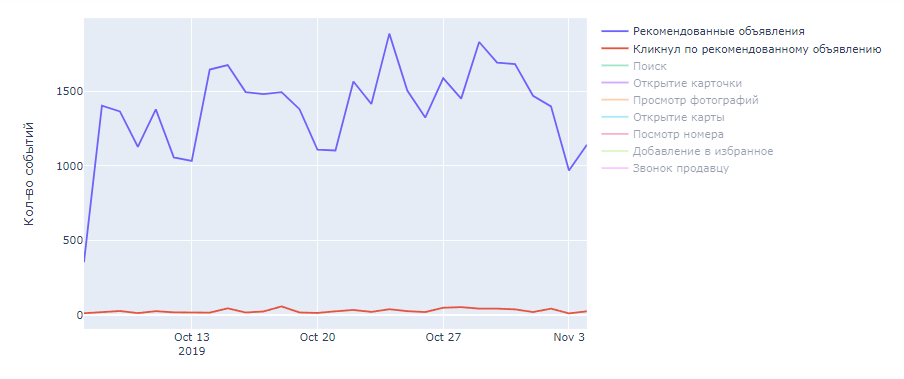

Возможно, объявления не соответствуют предпочтениям пользователей или плохо заметны. Не исключается вариант, что в первые минуты сессии объявлений очень много,  это приводит к мгновенному закрытию рекомендованного объявления, даже если оно было полезным

<a id="24"></a> 
### Расчет конверсии в целевое действие 'contacts_show'

In [92]:
tempo = (profiles['payer'].value_counts()[1]/len(profiles)*100).round(2)
print(f'Конверсия в целевое действие равна {tempo} %')


Конверсия в целевое действие равна 23.1 %


Показатель конверсии в 23% говорит нам о том, четверть пользователей становятся покупателями

<a id="25"></a> 
### Вывод по шагу

* пользователи часто возвращаются на следующий и на 2 день после регистрации
* около 91% пользователей совершают не более 3х сессией
* примерно 23% выполняют целевое действие

Из всего этого можно сделать выводы:

    * пользователи чаще ищут что-то конкретное
    * поиски занимают не более 3 сессий (редко 4 сессии)
    * четверть поисков заканчивается покупкой
        


<a id="3"></a> 
## Шаг. Разделение всех пользователей на группы

<a id="31"></a> 
### Распределение по источнику


В прошлых шагах была добавлена колонка 'source' в profiles которая показывает каким браузером пользуется тот или иной пользователь, посмотрим, как распределяются пользователи с разных браузеров. Eсли один из них сильно выделятся возможно стоит акцентировать на этом внимание, например, если значительное доля покупателей с одного браузера явно больше, чем с другого возможно какие-то баги или ошибки в данном приложении и разработчикам стоит обратить на это внимание. Так же если доли покупателей равные, но количество пользователей допустим из google значительно больше, то это тоже даст нам наводку о возможных дальнейших действиях, например, в google при запросе выдает ссылку на наш сайт первой строкой на Авито второй, а Yandex наоборот

In [93]:
profiles['source'].value_counts().sort_index()

google    1114
other     1197
yandex    1897
Name: source, dtype: int64

In [94]:

tempo = (profiles.groupby('source', as_index=False)
         .count()
         .loc[:, ['source', 'user_id']]).sort_values('user_id',ascending=False)




#гистограмма 
fig = px.histogram(tempo,
                   x='source',
                   y='user_id',
                   title='Количество пользователей пришедших из разных источников')

fig.show()

#круговой график             
fig = px.pie(tempo,
             values='user_id',
             names='source',
             labels = 'user_id',
             title='Отношение источников перехода в приложение')
fig.update_traces(textposition='inside',
                  textinfo='percent+value+label',
                  sort=False)

fig.show()

In [95]:
tempo

,source,user_id
2,yandex,1897
1,other,1197
0,google,1114


Около половины пользователей попадают в приложение через Yandex, и это в два раза больше чем через google, если рассматривать общие количество пользователей, то скорее всего ссылка на наш продукт в Yandex выпадет раньше, чем в google, от этого и недостаток пользователей из второго браузера

<a id="32"></a> 
### Retention rate для каждой группы

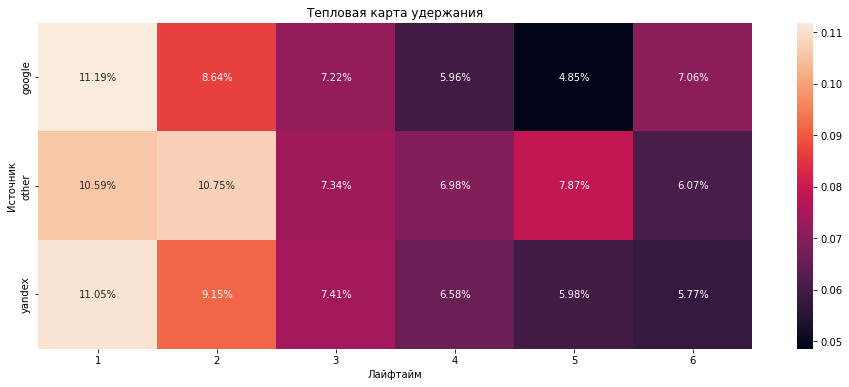

In [96]:
tempo = profiles.loc[:, ['user_id','first_ts','last_ts','source','dt']]
tempo['payer'] = True
dimensions= ['source']
(retention_raw,
 retention_grouped,
 retention_history) = get_retention(tempo,
                                      mobile_dataset,
                                      observation_date,
                                      horizon_days,                     
                                      dimensions=dimensions)

tempo = retention_history.reset_index().drop(columns=['payer','cohort_size', 0])
tempo = tempo.rename(columns={'source':'Источник'}).groupby('Источник').mean()

# строим хитмэп

plt.figure(figsize=(16, 6))  # задаём размер графика
sns.heatmap(
    tempo,  # удаляем лишние столбцы
    annot=True,  # включаем подписи
    fmt='.2%',  # переводим значения в проценты
)
plt.title('Тепловая карта удержания')  # название графика
plt.xlabel('Лайфтайм')
plt.show()

<a id="33"></a> 
### Конверсия для каждой группы

In [97]:
conversion = profiles.pivot_table(index='source', values = 'user_id', columns = 'payer', aggfunc = 'count')

conversion = conversion.reset_index()
conversion.columns = ['источник', 'пользователи','покупатели']
conversion['всего'] = conversion['пользователи']+conversion['покупатели']
conversion['конверсия'] = conversion['покупатели']/conversion['всего']*100
conversion

,источник,пользователи,покупатели,всего,конверсия
0,google,841,273,1114,24.506284
1,other,973,224,1197,18.713450
2,yandex,1422,475,1897,25.039536


Из Яндекса пришло больше пользователей и покупок они сделали больше, но конверсия у них с google одинаковая, примерно по 24.4%

<a id="4"></a> 
## Шаг. Проверка гипотез

<a id="41"></a> 
### Проверка гипотезы "различие конверсии пользователей Google и Yandex браузера"

In [98]:
conversion

,источник,пользователи,покупатели,всего,конверсия
0,google,841,273,1114,24.506284
1,other,973,224,1197,18.713450
2,yandex,1422,475,1897,25.039536


Сравним конверсию пользователей Google и Yandex браузера на равенство долей, критический уровень статистической значимости будем считать 5% 


Сформулируем гипотезы:   
Нулевая гипотеза: статистически значимых различий в конверсии между группами нет    
Альтернативная: статистически значение различия в конверсии между группами есть


In [99]:
conversion

,источник,пользователи,покупатели,всего,конверсия
0,google,841,273,1114,24.506284
1,other,973,224,1197,18.713450
2,yandex,1422,475,1897,25.039536


In [100]:
alpha = 0.05  # критический уровень статистической значимости

purchases = np.array([conversion.loc[0, 'покупатели'],
                      conversion.loc[2, 'покупатели']])
leads = np.array([conversion.loc[0, 'всего'],
                  conversion.loc[2, 'всего']])
# пропорция успехов в первой группе:
p1 = purchases[0]/leads[0]

# пропорция успехов во второй группе:
p2 = purchases[1]/leads[1]


# пропорция успехов в комбинированном датасете:
p_combined = (purchases[0] + purchases[1]) / (leads[0] + leads[1])

# разница пропорций в датасетах
difference = p1 - p2 

# ваш код

z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/leads[0] + 1/leads[1]))
distr = st.norm(0, 1)  
# ваш код
z_value = difference / mth.sqrt(
    p_combined * (1 - p_combined) * (1 / leads[0] + 1 / leads[1])
)
distr = st.norm(0, 1)

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    )

p-значение:  0.7437113523667942
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Данные говорят о том, что  между группами нет значимых различия, p-value = 0.744, а это больше 0.05 значит не отвергаем нулевую гипотезу.

Покупателей пришедших из Яндекса больше, но и общие количество пользователей из этого источника больше, поэтому если бы количество пользователей из google было бы таким же как в Yandex, количество покупателей в обоих случаях было бы примерно одинаковым, поэтому не стоит разделять пользователей по этому критерию

Показатель того что из Yandex приходит, почти в 2 раза пользователей может говорить о том, что ссылка конкурентов в google находится выше чем наша

<a id="42"></a> 
### Проверка гипотезы 
 "целевое действие('contacts_show') утром и днем происходит с одинаково часто"


Поделим пользователей на 3 группы:

    1) Пользователи которые делают целевое действие с 8.00 до 14.00(morning)
    2) Пользователи которые делают целевое действие с 14.00 до 20.00(day)
    3) Остальные пользователи (other)

Сформулируем гипотезы:

Нулевая гипотеза: статистически значимых различий в конверсии между группами нет     
Альтернативная: статистически значение различия в конверсии между группами есть

In [101]:
daytime = mobile_dataset.copy()

daytime['hour'] = daytime['event_time'].dt.hour
temp = daytime[daytime['event_name'] == 'contacts_show']
temp = temp['user_id'].unique()
daytime['daytime'] = 'other'
daytime['payer'] = False
for i in range(len(daytime)):        
    if daytime['user_id'][i] in temp:
        daytime.loc[i, 'payer']  = True
    if (daytime['hour'][i] >= 8 and
        daytime['hour'][i] < 14):
        daytime.loc[i, 'daytime']  = 'morning'
    elif (daytime['hour'][i] >= 14 and
          daytime['hour'][i] < 20):
        daytime.loc[i, 'daytime']  = 'day'


In [102]:
daytime = daytime.drop(columns=['event_time','event_name','source','dt','hour'])
daytime = daytime.drop_duplicates().reset_index(drop=True)
daytime = daytime.pivot_table(index = 'daytime', columns= 'payer', values ='user_id', aggfunc = 'count')
daytime['all'] = daytime[False]+daytime[True]
daytime

payer,False,True,all
daytime,,,
day,1731,668,2399
morning,1425,567,1992
other,1391,444,1835


Данная таблица показывает кол-во покупателей и пользователей, в каждый период суток, а также их сумму

 - morning действия происходили с 8 до 14 часов
 - day действия происходили с 14 до 20 часов
 - other действия происходили с 20 до 8 часов


 - False в действиях этих пользователей НЕ было обнаружено целевое действие 
 - True в действиях этих пользователей было обнаружено целевое действие 
 - all сумма пользователей за период 


In [103]:
alpha = 0.05  # критический уровень статистической значимости

purchases = np.array([daytime.loc['day', True],
                      daytime.loc['morning', True]])
leads = np.array([daytime.loc['day', 'all'],
                  daytime.loc['morning', 'all']])
# пропорция успехов в первой группе:
p1 = purchases[0]/leads[0]

# пропорция успехов во второй группе:
p2 = purchases[1]/leads[1]

# пропорция успехов в комбинированном датасете:
p_combined = (purchases[0] + purchases[1]) / (leads[0] + leads[1])

# разница пропорций в датасетах
difference = p1 - p2 

# ваш код

z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/leads[0] + 1/leads[1]))
distr = st.norm(0, 1)  
# ваш код
z_value = difference / mth.sqrt(
    p_combined * (1 - p_combined) * (1 / leads[0] + 1 / leads[1])
)
distr = st.norm(0, 1)

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    )

p-значение:  0.6497398674196391
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Судя по данным пользователи пользователи примерно с одинковой вероятностью выполняют целевое действие как утром там и после обеда

<a id="5"></a> 
## Шаг. Общий вывод

В распоряжении имеются данные за 28 дней со сведениями о:

* 4293 пользователях
* 74197 событиях


В ходе исследования былы проделаны следующие шаги 

1) предобработка данных 

    - проверка данных на ошибки и аномалии
    - изменение типив данных
    - удаление дубликатов
    - добавление необходимых столбцов
    
    
2) анализ данных

    - подсчет retention rate
    - расчет времени которое пользователи проводят в приложение
    - расчет частоты проведений событий
    - расчет конверсии в целевое действие 'contacts_show'
    
    
3) Разделение всех пользователей на группы

    - распределение по браузеру(гугл, яндекс, другие)
    - для каждой группы расчитали Retention rate    
    - для каждой группы расчитали конверсию
   
4) Проверка гипотез

    - проверили гипотезы "различие конверсии пользователей гугл браузера и яндекс браузера"
    - проверили гипотезы "целевое действие('contacts_show') происходит чаще днем чем вечером"
    


<a id="51"></a> 
### Вывод

Разницы конверсии пользователей Google и Yandex браузера не выявлено, из этого следует, что поток покупателей из этих источников одинаковый

Разница в размере пользователей Google и Yandex браузера говорит о том, что с Google браузера приходит меньше пользователей

Пользователи совершают целевое действие в течении дня равномерно

Пользователи проводят в приложении примерно 10-15 минут за сессию

Пользователи часто возвращаются на следующий и на 2 день после регистрации

около 91% пользователей совершают не более 3х сессией

Примерно 23% пользователей выполняет целевое действие  


<a id="52"></a> 
### Рекомендации

1) отправка push-уведомлений 

   - если пользователь в течении дня просматривал объявления рекомендую напомнить ему об этом часов в 18-19, когда он возвращаются с работы, так как в это время самое большое кол-во просмотров контактов (целевое действие), это должно повысить конверсию
   - если пользователь в течении нескольких дней не вернулся в приложении рекомендую напомни ему об его поиске, так как пользователи обычно не возвращаются в приложении после 2-3 дней
   


2) увеличении источников привлечения и рекламы

   - 23% хороший показатель конверсии, а значит, чем больше пользователей придет в приложение, тем больше выручки они принесут компании
   - так же рекомендую разобраться почему с Yandex приходит почти в 2 раза больше пользователей, чем Google

In [104]:
# файлы для дашборда
mobile_dataset = mobile_dataset.drop(columns=['event_time'])
mobile_dataset.columns = ['eventname', 'userid','source', 'dt']
mobile_dataset.to_csv('dash_dataset.csv', index=False)
profiles.to_csv('dash_profiles.csv', index=False)

In [105]:
#проверка
pd.read_csv('dash_dataset.csv')

,eventname,userid,source,dt
0,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07
1,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07
2,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07
3,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07
4,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07
...,...,...,...,...
74192,map,d157bffc-264d-4464-8220-1cc0c42f43a9,google,2019-11-04
74193,advert_open,d157bffc-264d-4464-8220-1cc0c42f43a9,google,2019-11-04
74194,tips_show,d157bffc-264d-4464-8220-1cc0c42f43a9,google,2019-11-04
74195,advert_open,d157bffc-264d-4464-8220-1cc0c42f43a9,google,2019-11-04


In [106]:
#проверка
pd.read_csv('dash_profiles.csv')

,user_id,first_ts,last_ts,source,dt,payer,count_session,session_length_s,avg_time_session_m
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:39:46,2019-10-22 11:30:53,other,2019-10-07,False,4,2760.0,12.0
1,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-19 21:34:34,2019-11-03 17:12:10,yandex,2019-10-19,True,5,11775.0,39.0
2,00463033-5717-4bf1-91b4-09183923b9df,2019-11-01 13:54:35,2019-11-01 14:19:18,yandex,2019-11-01,False,1,1483.0,25.0
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,2019-10-18 22:14:06,2019-10-31 21:42:16,google,2019-10-18,False,6,6644.0,18.0
4,00551e79-152e-4441-9cf7-565d7eb04090,2019-10-25 16:44:41,2019-10-29 02:17:12,yandex,2019-10-25,True,2,560.0,5.0
...,...,...,...,...,...,...,...,...,...
4203,ffab8d8a-30bb-424a-a3ab-0b63ebbf7b07,2019-10-13 16:11:27,2019-10-26 19:53:52,yandex,2019-10-13,False,2,2965.0,25.0
4204,ffc01466-fdb1-4460-ae94-e800f52eb136,2019-10-07 20:32:50,2019-10-07 20:33:42,yandex,2019-10-07,True,1,52.0,1.0
4205,ffcf50d9-293c-4254-8243-4890b030b238,2019-10-23 11:51:35,2019-10-23 11:52:56,google,2019-10-23,False,1,81.0,1.0
4206,ffe68f10-e48e-470e-be9b-eeb93128ff1a,2019-10-21 16:39:34,2019-10-28 07:17:53,yandex,2019-10-21,True,3,2332.0,13.0
